In [1]:
import socket
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
def le_dados_imu(N, func=None, endereco = "shaka", porta=1234):
    dd = []
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((endereco, porta))
        for i in range(N):
            data = s.recv(32)
            ax = int.from_bytes(data[0:2], byteorder='big', signed=True)
            ay = int.from_bytes(data[2:4], byteorder='big', signed=True) 
            az = int.from_bytes(data[4:6], byteorder='big', signed=True) 
            temp = int.from_bytes(data[6:8], byteorder='big', signed=True) 
            wx = int.from_bytes(data[8:10], byteorder='big', signed=True)
            wy = int.from_bytes(data[10:12], byteorder='big', signed=True)
            wz = int.from_bytes(data[12:14], byteorder='big', signed=True)
            mx = int.from_bytes(data[14:16], byteorder='big', signed=True)
            my = int.from_bytes(data[16:18], byteorder='big', signed=True)
            mz = int.from_bytes(data[18:20], byteorder='big', signed=True)
            t = int.from_bytes(data[-8:], byteorder='little', signed=False)
            dd.append([ax, ay, az, wx, wy, wz, mx, my, mz, temp, t])
            if func:
                func(i)
    return dd

In [14]:
res2x = np.loadtxt("res2x.txt")
Q = np.loadtxt("Q.txt")
scale = 0.000598
gy_scale= 0.001064724
mag_scale = 0.001810
print(res2x)

[-181.4548672  -151.19968288  119.58441564    0.99810697    0.99971396
    0.98932928]


In [ ]:
dados = le_dados_imu(6000, lambda i : print("Coletando dados: " + str(int(100*(i+1)/6000))+ "%", end="\r"))
np.savetxt("GyroParado.txt", np.array(dados)[:,3:6])


In [5]:

gp = np.loadtxt("GyroParado.txt")
gyOffset = np.average(gp,0)
print(gyOffset)
np.savetxt("gyOffset.txt",gyOffset)

[-34.82366667   5.474      -16.5495    ]


In [12]:
def getRobotGy(gy):
    return (Q@(np.array(gy)-gyOffset))

[-1.692000e+03  2.020000e+02  1.636800e+04 -3.200000e+01  6.000000e+00
 -1.600000e+01 -1.260000e+02  1.100000e+02 -1.000000e+02  2.227000e+03
  1.748444e+18]


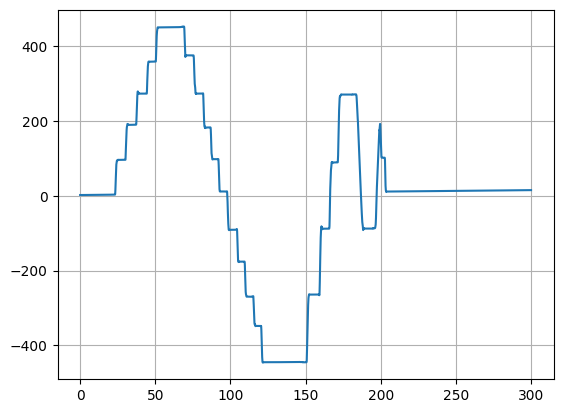

In [29]:
allData = np.loadtxt("orientados.txt")

gy = allData[:,3:6]
Time = allData[:,10]
print(allData[0])
W_Ant, theta = 0,0
T0= Time[0]
T_ant = T0
X = np.zeros(len(Time))
Y = np.zeros(len(Time))
for i in range(len(Time)):
    X[i] = (Time[i]-T0)/1e9 # ns to s
    #print(Time[i])
    dt =(Time[i] - Time[i-1])/1e9
    #print(dt)
    W =getRobotGy(gy[i]) 
    wz = W[2]*180/np.pi*gy_scale

    theta += (wz+W_Ant)/2*dt
    W_Ant=wz
    Y[i]=theta

plt.plot(X,Y)
plt.grid(True)
plt.show()